In [3]:
%matplotlib inline
import pygame
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython import display
from tensorflow import keras
import math
import time
import tensorflow as tf

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [22]:
class DoubleUtil:
    def __init__(self, _decaysteps = 50, _decayrate = 0.9, max_history = 10000, batch_size = 200, tau = 0.08):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps = _decaysteps, decay_rate = _decayrate))
        self.max_history = max_history
        self.replay_history = []
        self.current_experience = 0
        self.batch_size = batch_size
        self.tau = tau
        
    def save_experience(self, current_state, action, reward, next_state):
        if self.current_experience < self.max_history:            
            self.replay_history.append([current_state, action, reward, next_state])
        else:
            self.replay_history[self.current_experience % self.max_history] = [current_state, action, reward, next_state]
        self.current_experience += 1
    
    def sample_from_experience(self):
        if self.current_experience >= self.batch_size:
            batch = random.sample(self.replay_history, self.batch_size)
        else:
            batch = random.sample(self.replay_history, len(self.replay_history))
        return batch
    
    
    def double_td_loss(self, online_nn, target_nn, discount = 0.99):
        #use online network to evaluate greedy policy and the target for calue estimation
        loss = []
        #BINARY BECAUSE THE ACTION SPACE IS ONLY 0 OR 1
        sampled_experiences = self.sample_from_experience()
        random.shuffle(sampled_experiences)
        for current_state, action, reward, next_state in sampled_experiences:
            b_action = [0.0] * online_nn.output.shape[1]
            onn_next_act = tf.math.argmax(tf.reshape(online(tf.convert_to_tensor([next_state])), [-1])).numpy() 
            b_action[onn_next_act] = 1.0
            b_action = tf.constant([b_action])
            
            tnn_next = tf.math.reduce_max(target_nn(tf.convert_to_tensor([next_state])))
            onn_current = online_nn(tf.convert_to_tensor([current_state]))           
            
            #get current Q value from network
            #current_q = nn(tf.convert_to_tensor([current_state]))
            loss.append(tf.math.square((reward + discount * tnn_next - onn_current) * b_action))
        return tf.math.reduce_mean(loss, axis=0)
        
    def update_double_model(self, online, target):
        with tf.GradientTape() as tape:
            loss = self.double_td_loss(online, target)
            grads = tape.gradient(loss, online.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, online.trainable_variables))
            return loss
            
    def update_target_weights(self, online, target):
        target.set_weights(online.get_weights())

In [19]:
class DA:
    def __init__(self, obs_shape, act_size):
        self.obs_shape = obs_shape
        self.act_size = act_size
    def network (self, train = True, node_size = 64, a_function = tf.keras.layers.LeakyReLU()):
        inputs = tf.keras.Input(shape=(self.obs_shape,),name="input")
        x = tf.keras.layers.Dense(node_size, activation=a_function,name="dense_1")(inputs)
        x = tf.keras.layers.Dense(node_size, activation=a_function,name="dense_2")(x)
        outputs = tf.keras.layers.Dense(self.act_size, name="output")(x)
        online = tf.keras.models.Model(inputs = inputs, outputs=outputs, name="online_nn", trainable=train)
        
        inputs_t = tf.keras.Input(shape=(self.obs_shape,),name="input")
        x_t = tf.keras.layers.Dense(node_size, activation=a_function,name="dense_1")(inputs_t)
        x_t = tf.keras.layers.Dense(node_size, activation=a_function,name="dense_2")(x_t)
        outputs_t = tf.keras.layers.Dense(self.act_size, name="output")(x_t)
        target = tf.keras.models.Model(inputs = inputs_t, outputs=outputs_t, name="target_nn", trainable=train)        
        return online, target


In [20]:
env = gym.make('CartPole-v1')
online, target = DA(4,2).network(node_size = 128)
util = DoubleUtil(batch_size=128)
e = 1
max_e = 1
min_e = 0.01
i, early_stop = 0,0
number_of_episodes = 2000
tau = 20
update_target = 150
rewards = []
avg_losses = []
total_iterations = 0
while i < number_of_episodes:
    current_state = env.reset()
    step = 0
    avg_loss = 0
    while True:
        total_iterations += 1
        r = np.random.uniform()
        #EXPLORATION VS EXPLOITATION
        if r < e:
            action = env.action_space.sample()
        else:
            #sample action from the network by picking highest output from the nn, convert to numpy
            #if swap:
                #action = tf.math.argmax(tf.reshape(target(tf.convert_to_tensor([current_state])), [-1])).numpy()
            #else:
            action = tf.math.argmax(tf.reshape(online(tf.convert_to_tensor([current_state])), [-1])).numpy()
        next_state, reward, done, info = env.step(action)
        step+=1
        util.save_experience(current_state, action, reward, next_state)
        
        if(total_iterations % tau) == 0:
            avg_loss += np.mean(util.update_double_model(online, target))
        
        current_state = next_state
        
        if(total_iterations % update_target) == 0:
            util.update_target_weights(online,target)
        #e decay
        
        e = max(e * 0.99, min_e)
        if done:
            avg_losses.append(avg_loss)
            rewards.append(step)
            i+=1
            if step >= 500:
                early_stop+=1
            else:
                early_stop = 0
            if early_stop >= 10:
                i = number_of_episodes
            break

<Figure size 432x288 with 0 Axes>

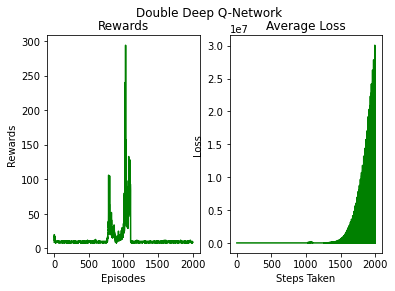

In [21]:
fig = plt.figure()
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)    
ax2 = fig.add_subplot(1,2,2)
ax1.plot(np.arange(len(rewards)),rewards,c='g')
ax1.set_title("Rewards")
ax1.set_ylabel("Rewards")
ax1.set_xlabel("Episodes")
ax2.plot(np.arange(len(avg_losses)), avg_losses, c='g')

ax2.set_title("Average Loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Steps Taken")
fig.suptitle("Double Deep Q-Network")
fig.savefig('figures/ddqn_2')